## Prepare data

In [2]:
import json
with open('shipsnet.json') as json_file:
    raw_data = json.load(json_file)
    image = raw_data['data']
    label = raw_data['labels']      

In [3]:
len(image[0])

19200

In [6]:
import numpy as np
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

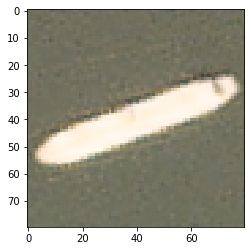

In [7]:
plt.imshow( np.reshape( np.array(image[999]),(80,80,3),order='F' ) )

In [8]:
x = np.reshape( np.array(image), [4000,80,80,3], order='F' )  
y = label

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)

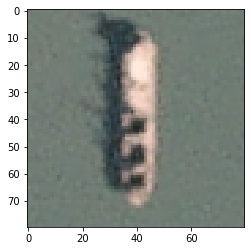

In [10]:
plt.imshow(x_test[100])

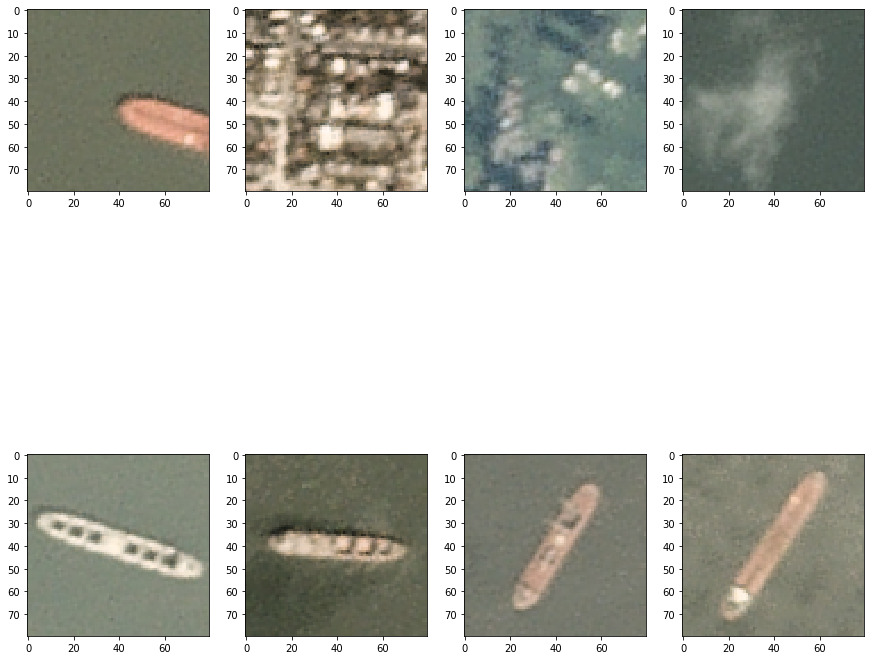

In [11]:
for i in range(1,3):
    index = np.where(y_train == i-1 )[0]
    for j in range(1,5):
        plt.figure( 1,figsize=(15,15))
        plt.subplot( 2,4,(i-1)*4+j )
        plt.imshow(x_train[index[j]]  )
        
plt.show()
    

## Modeling

In [12]:
import os
from tensorflow import keras
import numpy as np
import math

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint

In [13]:
batch_size = 64

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip = True)

train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train,batch_size=batch_size)

validation_generator = test_datagen.flow(x_test, y_test,batch_size=batch_size)

In [14]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [15]:
from tensorflow.keras.backend import resize_images
from tensorflow.keras.layers import Input, concatenate
img_input=Input(shape=(80,80,3))
resize_tensor= resize_images(img_input,2.8,2.8,data_format= "channels_last")
input_model = Model( inputs= img_input,outputs = resize_tensor)

In [16]:
pre_trained_model = MobileNetV2(include_top=True,input_tensor = input_model.output)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [32]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape_1 (TensorFlow [(4,)]               0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(2,)]               0           tf_op_layer_Shape_1[0][0]        
__________________________________________________________________________________________________
tf_op_layer_mul_1 (TensorFlowOp [(2,)]               0           tf_op_layer_strided_slice_1[0][0]
_______________________________________________________________________________

In [17]:
last_layer = pre_trained_model.layers[-2].output

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from cyclical_learning_rate import CyclicLR
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_layer)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(32, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.3)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.3)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
clr = CyclicLR(base_lr=0.0001, max_lr=0.001, step_size=20., scale_fn=clr_fn,scale_mode='cycle')

callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=1), clr]

model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])



In [21]:
model.summary()

[0][0]             
__________________________________________________________________________________________________
block_7_expand_relu (ReLU)      (None, 14, 14, 384)  0           block_7_expand_BN[0][0]          
__________________________________________________________________________________________________
block_7_depthwise (DepthwiseCon (None, 14, 14, 384)  3456        block_7_expand_relu[0][0]        
__________________________________________________________________________________________________
block_7_depthwise_BN (BatchNorm (None, 14, 14, 384)  1536        block_7_depthwise[0][0]          
__________________________________________________________________________________________________
block_7_depthwise_relu (ReLU)   (None, 14, 14, 384)  0           block_7_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_7_project (Conv2D)        (None, 14, 14, 64)   24576       block_7_depthwise_relu[0

## training

In [22]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = len(x_train)//batch_size,
            epochs = 80,
            validation_steps = len(x_test)//batch_size,
            verbose = 1,
            callbacks=callbacks)

Epoch 1/80
50/50 [==============================] - 15s 295ms/step - loss: 0.5525 - acc: 0.7056 - val_loss: 0.4354 - val_acc: 0.8542
Epoch 2/80
50/50 [==============================] - 13s 255ms/step - loss: 0.3839 - acc: 0.8197 - val_loss: 0.4015 - val_acc: 0.8281
Epoch 3/80
50/50 [==============================] - 13s 260ms/step - loss: 0.3633 - acc: 0.8241 - val_loss: 0.4133 - val_acc: 0.8021
Epoch 4/80
50/50 [==============================] - 13s 255ms/step - loss: 0.3154 - acc: 0.8575 - val_loss: 0.3826 - val_acc: 0.8073
Epoch 5/80
50/50 [==============================] - 13s 258ms/step - loss: 0.2982 - acc: 0.8734 - val_loss: 0.3520 - val_acc: 0.8177
Epoch 6/80
50/50 [==============================] - 13s 256ms/step - loss: 0.2774 - acc: 0.8847 - val_loss: 0.4032 - val_acc: 0.7969
Epoch 7/80
50/50 [==============================] - 13s 257ms/step - loss: 0.2715 - acc: 0.8872 - val_loss: 0.4149 - val_acc: 0.8073
Epoch 8/80
50/50 [==============================] - 13s 257ms/step - 

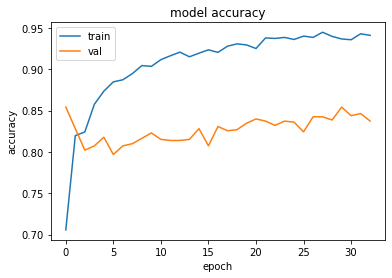

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

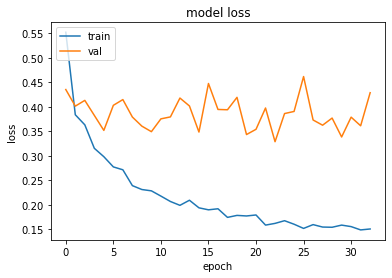

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Mark all the ships in the scene image
copyright@ The method we are using comes from https://www.kaggle.com/byrachonok/keras-for-search-ships-in-satellite-image

In [25]:
from PIL import Image, ImageDraw 
import sys

### display one example

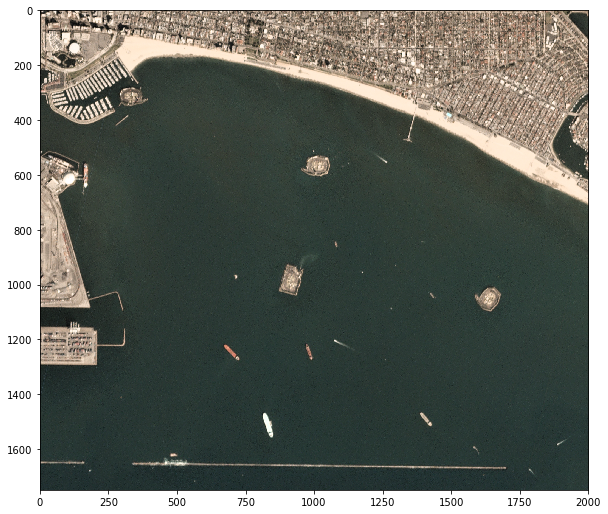

In [26]:
image = Image.open('lb_1.png')
pic_array = np.array( image )
plt.figure(1, figsize = (15, 30))
plt.subplot(3, 1, 1)
plt.imshow(pic_array)
plt.show()

In [27]:
picture_tensor = pic_array.transpose(2,0,1)

In [28]:
pic_array.shape

(1749, 2001, 3)

In [29]:
height = pic_array.shape[0]
width = pic_array.shape[1]

In [30]:

def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study


def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

X:1550 Y:440  [[0.87676877]]


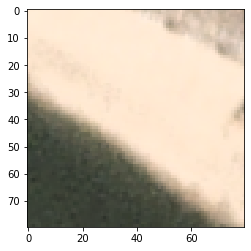

X:130 Y:570  [[0.8185491]]


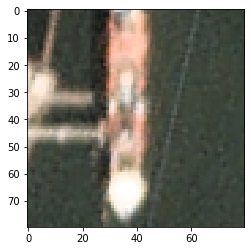

X:620 Y:1170[[0.8487519]]


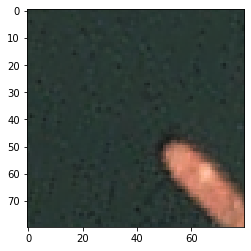

X:940 Y:1170[[0.8788265]]


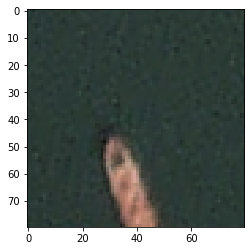

X:1360 Y:1420[[0.8910758]]


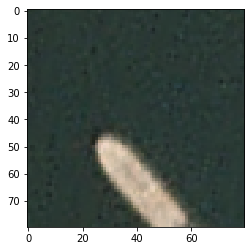

X:770 Y:1430  [[0.87299335]]


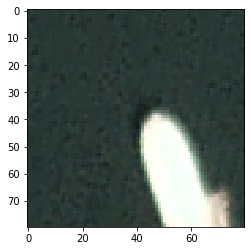

X:1560 Y:1540  [[0.8265026]]


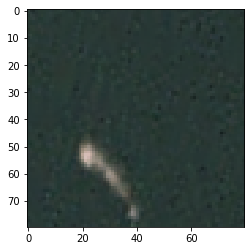

X:320 Y:1580[[0.8627502]]


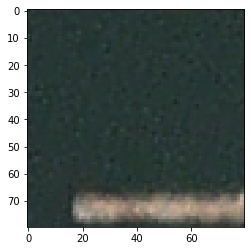

X:1280 Y:1600  [[0.83389294]]


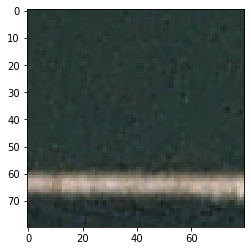

X:1630 Y:1630  [[0.8022137]]


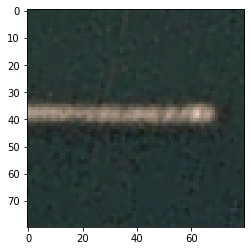

X:1920 Y:1660

In [32]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][0] > 0.80 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [33]:
coordinates[0]

[[1550, 440], array([[0.87676877]], dtype=float32)]

In [34]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][0])

In [35]:
picture_tensor = picture_tensor.transpose(1,2,0)

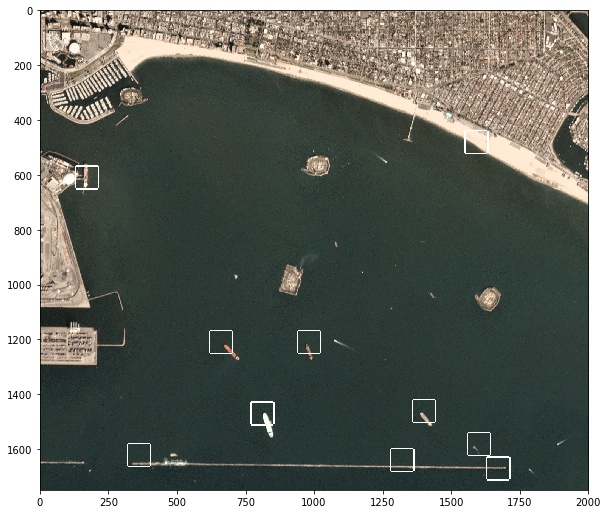

In [36]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()